In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
import multiprocessing as mp 

import pandas
pandas.set_option('display.max_columns', None)

import scienceplots
plt.style.use(['science', 'notebook', 'grid']) 
plt.rcParams['figure.figsize'] = [8 , 8]

# Importing data

In [2]:
def Plot(x_data, y_data, x_label='', y_label='', xbins=20, hist2d_nbins=200, x_min=None, x_max=None, y_min=None, y_max=None, xlog=True, ylog=True):
    plt.rcParams['figure.figsize'] = [16 , 8]
    fig, axes = plt.subplots(1, 2)
    
    if x_min==None: x_min = np.min(x_data)
    if x_max==None: x_max = np.max(x_data)
    if y_min==None: y_min = np.min(y_data)
    if y_max==None: y_max = np.max(y_data)


    # First Plot
    ax = axes[0]
    ax.set_title(f'Means of {int(xbins)} log-spaced bins')
    bin_edges = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=xbins+1)
    statistics = np.zeros(shape=(int(xbins), 5))
    
    for i in range(int(xbins)):
        mask_bin = ((x_data>=bin_edges[i]) & (x_data<bin_edges[i+1]))
        x_temp = np.array(x_data[mask_bin])
        y_temp = np.array(y_data[mask_bin])
        N_temp = int(len(x_temp))
        statistics[i] = np.array([N_temp, 
                                  np.mean(x_temp), 
                                  np.std(x_temp, ddof=1)/np.sqrt(N_temp), 
                                  np.mean(y_temp), 
                                  np.std(y_temp, ddof=1)/np.sqrt(N_temp)])

    ax.errorbar(x=statistics[:,1], 
                y=statistics[:,3], 
                xerr=statistics[:,2], 
                yerr=statistics[:,4], 
                fmt='.', color='blue', ecolor='grey', capsize=4, capthick=1)
    
    x_min_bins = np.min(statistics[:,1])
    x_max_bins = np.max(statistics[:,1])
    y_min_bins = np.min(statistics[:,3])
    y_max_bins = np.max(statistics[:,3])
    
    if xlog==True: 
        ax.set_xscale('log')
        ax.set_xlim(0.5*x_min_bins, 1.5*x_max_bins)
    else: 
        ax.set_xlim(0.99*x_min_bins, 1.01*x_max_bins)
        
    if ylog==True: 
        ax.set_yscale('log')
        ax.set_ylim(0.5*y_min_bins, 1.5*y_max_bins)
    else:
        ax.set_ylim(0.95*y_min_bins, 1.05*y_max_bins)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)


    # Second Plot
    ax = axes[1]
    ax.set_title(f'2-D histogram of the data')
    binx = np.logspace(start=np.log10(x_min), stop=np.log10(x_max), num=hist2d_nbins)
    biny = np.logspace(start=np.log10(y_min), stop=np.log10(y_max), num=hist2d_nbins)
    hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
    
    if xlog==True: ax.set_xscale('log')
    if ylog==True: ax.set_yscale('log')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
    fig.colorbar(hist[3], cax=cax)
    
    
    plt.show()
    
    return fig, axes, statistics, hist

In [3]:
results = Table.read('./out_full/results.fits', format='fits')
results = results.to_pandas()
results

,id,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.sdss.gp,bayes.sdss.gp_err,bayes.sdss.ip,bayes.sdss.ip_err,bayes.sdss.rp,bayes.sdss.rp_err,bayes.sdss.up,bayes.sdss.up_err,bayes.sdss.zp,bayes.sdss.zp_err,best.chi_square,best.reduced_chi_square,best.attenuation.B_B90,best.attenuation.E_BVs.nebular.continuum_old,best.attenuation.E_BVs.nebular.continuum_young,best.attenuation.E_BVs.nebular.lines_old,best.attenuation.E_BVs.nebular.lines_young,best.attenuation.E_BVs.stellar.old,best.attenuation.E_BVs.stellar.young,best.attenuation.FUV,best.attenuation.V_B90,best.attenuation.ebvs_old_factor,best.attenuation.powerlaw_slope,best.attenuation.uv_bump_amplitude,best.attenuation.uv_bump_wavelength,best.attenuation.uv_bump_width,best.nebular.f_dust,best.nebular.f_esc,best.nebular.lines_width,best.nebular.logU,best.nebular.ne,best.nebular.zgas,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.metallicity,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.attenuation.nebular.continuum_old,best.attenuation.nebular.continuum_young,best.attenuation.nebular.lines_old,best.attenuation.nebular.lines_young,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.luminosity,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.stellar.lum,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.lum_old,best.stellar.lum_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.sdss.up,best.sdss.gp,best.sdss.rp,best.sdss.ip,best.sdss.zp
0,1237657873254907919,0.024257,0.148864,0.034852,0.180222,0.024923,0.150864,0.813277,0.064224,1.966500,0.049148,1.459651,0.023274,0.161777,0.016154,2.532923,0.126091,7.830311,1.957578,1.331683,0.264,0.60,0.264,0.60,0.264,0.60,2.621240,1.072804,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,647.0,20.0,0.0,0.1,46.5,600.703624,1.0,0.02,10.0,13368.111980,3.803276e+24,0.028312,5.055656e+32,1.299495e+31,1.112661e+33,2.733061e+31,2.468935e+36,2.327126e+32,2.470826e+36,5.658388e+09,1.114690e-04,3.891712e-04,1.230300e-04,5.279591e+36,3.974634e+33,3.919185e+33,5.544877e+31,5.279295e+36,2.953351e+32,2.062985e+09,2.062985e+09,7.630566e+01,3.595402e+09,3.595401e+09,1.153994e+03,7.954457e+50,7.786732e+50,1.677245e+49,0.163447,0.855873,1.471915,1.969252,2.509335
1,1237657873254973544,1.703986,1.943519,2.361601,3.351815,1.720523,1.963627,0.242112,0.012637,0.443666,0.014797,0.344725,0.011248,0.093262,0.009139,0.522656,0.030554,0.118907,0.029727,0.249372,0.044,0.10,0.044,0.10,0.044,0.10,0.737715,0.193441,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1500.0,20.0,0.0,0.1,541.0,1042.152363,1.0,0.02,10.0,13003.015620,7.708407e+24,0.056195,1.829330e+32,2.316632e+34,4.615793e+32,5.564139e+34,4.149507e+35,4.743766e+35,9.687794e+35,3.278326e+09,4.043335e-01,4.437052e-01,4.077165e-01,3.973401e+36,1.988034e+35,3.698753e+33,1.951046e+35,2.966458e+36,1.006943e+36,1.277028e+09,1.276785e+09,2.426724e+05,2.001298e+09,1.997463e+09,3.834491e+06,5.996591e+52,8.757685e+50,5.909014e+52,0.091143,0.253507,0.362687,0.441209,0.500566
2,1237654880726286453,0.912346,1.924841,0.939005,1.961911,0.914507,1.927816,0.207874,0.011325,0.654413,0.019171,0.456883,0.019417,0.044528,0.005430,0.878735,0.046464,0.082754,0.020689,0.770858,0.154,0.35,0.154,0.35,0.154,0.35,1.555298,0.623578,0.44,0.0,0.0,217.5,35.0,0.0,0.0,300.0,-2.0,100.0,0.02,1500.0,20.0,0.0,0.1,46.5,1453.856923,1.0,0.02,10.0,12764.994344,1.042477e+25,0.074970,1.652499e+33,4.475367e+23,3.824081e+33,9.634630e+23,2.570888e+36,8.364153e+24,2.576364e+36,1.980224e+10,4.211531e-12,1.470370e-11,4.648328e-12,9.388564e+36,1.550025e+34,1.550025e+34,2.094970e+

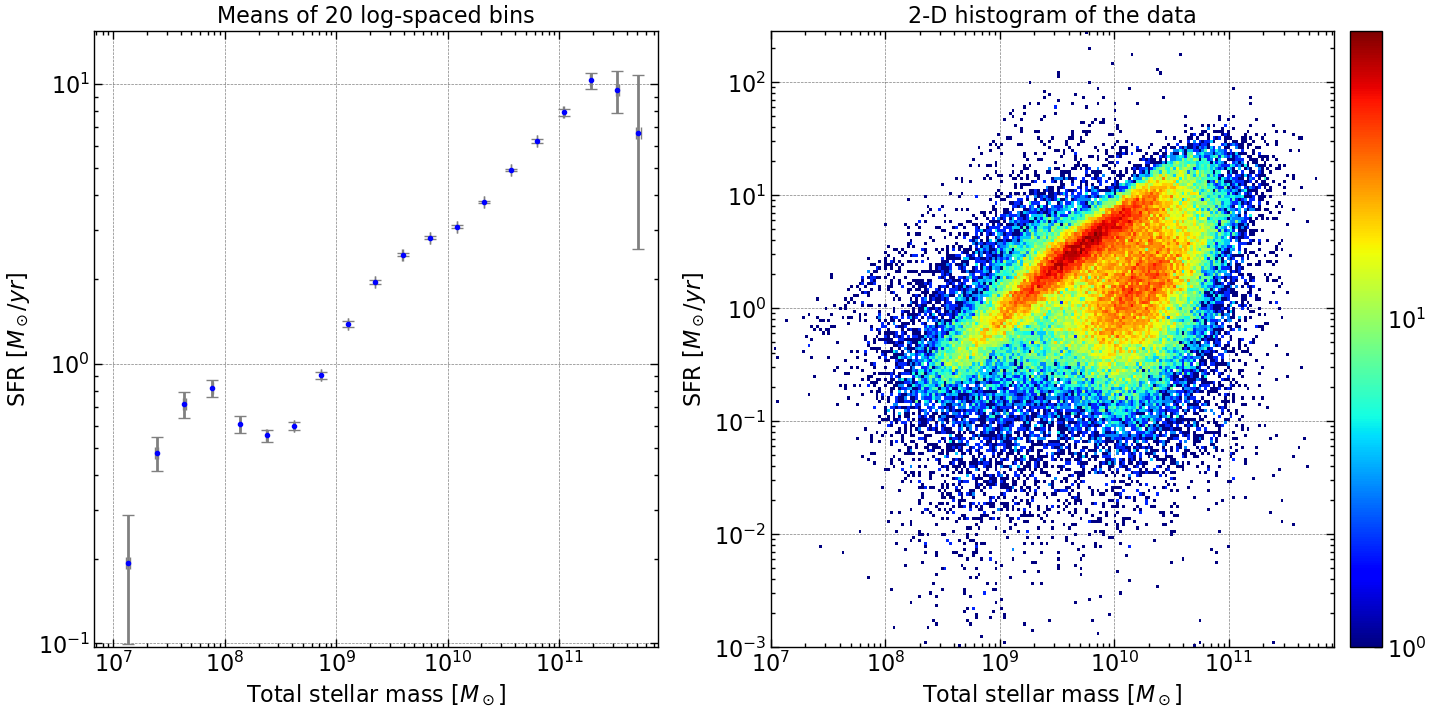

bins occupation = [    9    28    41   152   495  1117  2327  3662  5655  8113 10773 13818
 16417 14943  9293  4121  1195   243    42     3]


In [4]:
x_data = results['best.stellar.m_star']
y_data = results['bayes.sfh.sfr10Myrs']

fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'SFR $[M_\odot/yr]$', xbins=20, x_min=1e7, y_min=1e-3);
print(f'bins occupation = {statistics[:,0].astype(int)}')

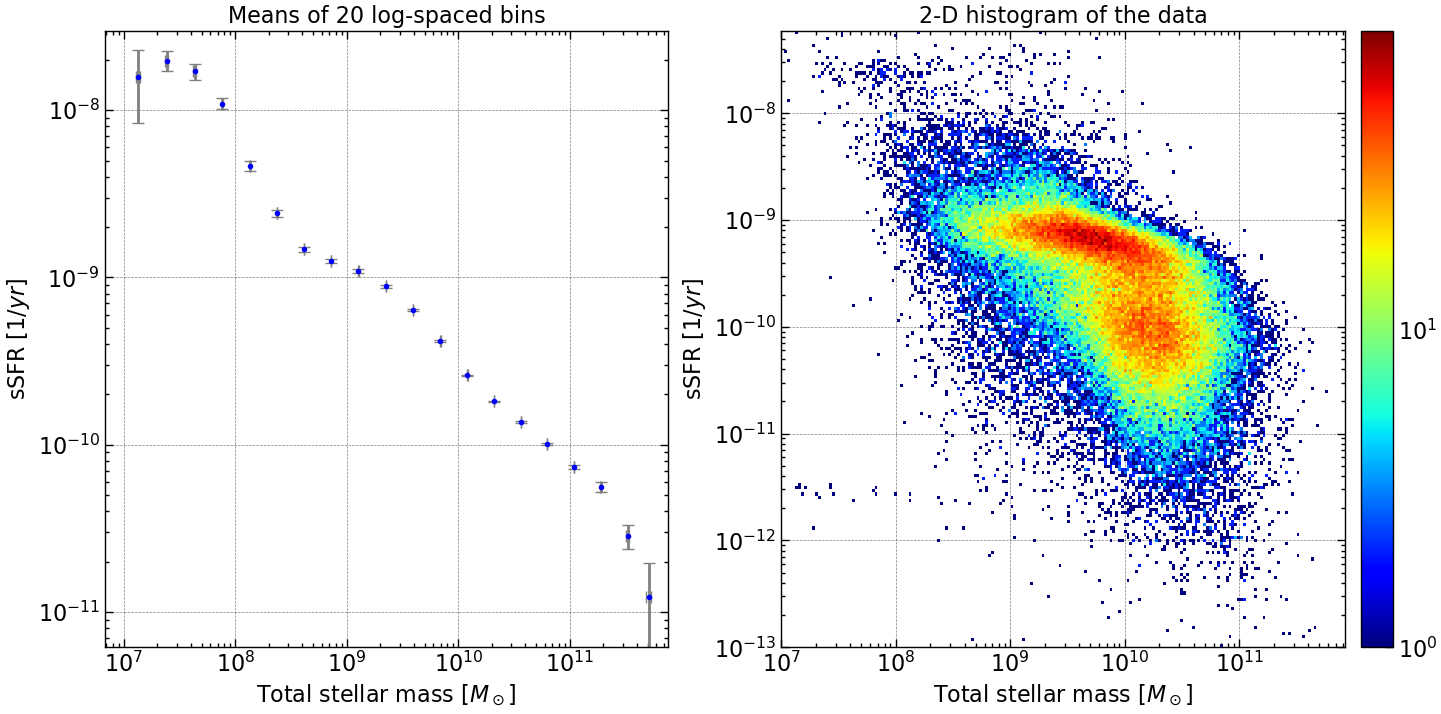

bins occupation = [    9    28    41   152   495  1117  2327  3662  5655  8113 10773 13818
 16417 14943  9293  4121  1195   243    42     3]


In [5]:
x_data = results['best.stellar.m_star']
y_data = results['bayes.sfh.sfr10Myrs']/results['best.stellar.m_star']
    
fig, ax, statistics, hist = Plot(x_data, y_data, 'Total stellar mass $[M_\odot]$', 'sSFR $[1/yr]$', xbins=20, hist2d_nbins = 200, x_min=1e7, y_min=1e-13);
print(f'bins occupation = {statistics[:,0].astype(int)}')

# Clustering 

## 1) KMeans

[KMeans Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [6]:
from sklearn.cluster import KMeans

X = np.array([np.log10(x_data), np.log10(y_data)]).T

n_clusters = 2
#centers = np.array([[9.3, 0.2], [10.1, 0.01]]) 
clf = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto', verbose=True)
clf.fit(X)
labels = clf.predict(X)  

Initialization complete
Iteration 0, inertia 64043.18744238974.
Iteration 1, inertia 36313.94330992654.
Iteration 2, inertia 35385.949856443905.
Iteration 3, inertia 35092.46503680609.
Iteration 4, inertia 34990.981892309224.
Iteration 5, inertia 34954.218416291944.
Iteration 6, inertia 34939.31362471538.
Iteration 7, inertia 34933.31839241158.
Converged at iteration 7: center shift 3.437671568732319e-05 within tolerance 3.924852994324649e-05.


In [7]:
def PlotClusters(labels):
    labels_unique = np.unique(labels)
    n_clusters = len(labels_unique[labels_unique >= 0])
    print(f'labels = {labels_unique}')
    print("number of estimated clusters :", n_clusters)
    
    fig = plt.figure(figsize=(12,8))
    plt.scatter(X[labels==-1,0], X[labels==-1,1], color='gray', alpha=0.5)
    for i in range(n_clusters):
        plt.scatter(X[labels==i,0], X[labels==i,1], alpha=0.5)
    plt.xlabel('Total stellar mass $[M_\odot]$')
    plt.ylabel('sSFR $[1/yr]$')
    
    return fig

labels = [0 1]
number of estimated clusters : 2


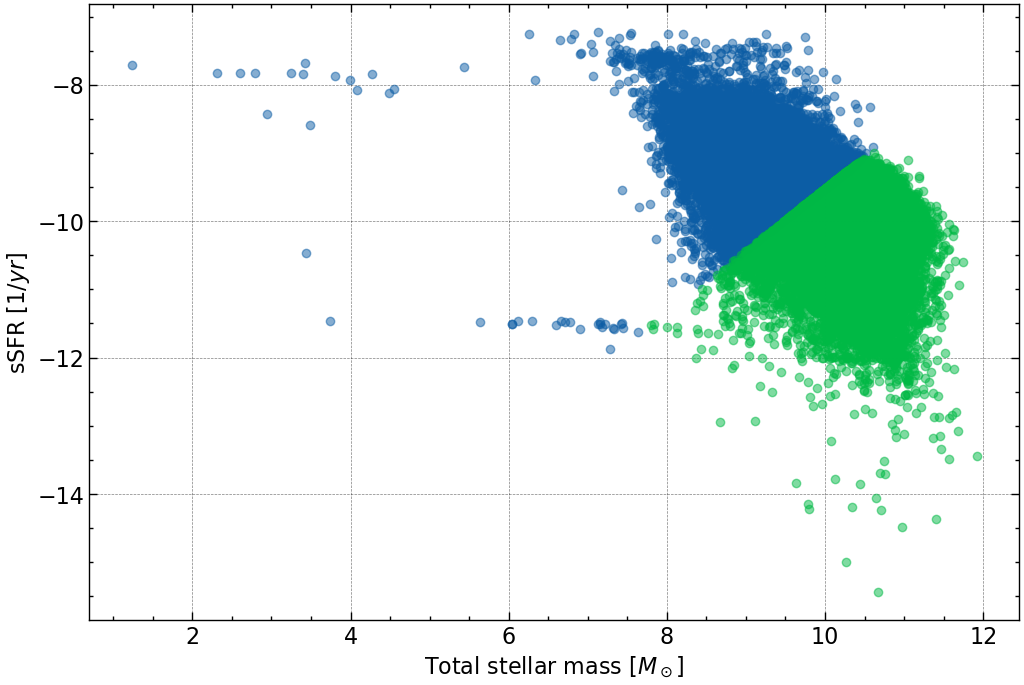

In [8]:
fig = PlotClusters(labels)

## 2) MeanShift

[MeanShift Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html)

[estimate_bandwidth Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.estimate_bandwidth.html)

In [9]:
from sklearn.cluster import MeanShift
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
bandwidth = 0.7 # Determined by using sklearn.cluster.estimate_bandwidth()

#from sklearn.cluster import estimate_bandwidth
#bandwidth = estimate_bandwidth(X, n_jobs=int(mp.cpu_count()/2)) # This takes a long time...beware

In [10]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, n_jobs=int(mp.cpu_count()/2))
ms.fit(scaler.fit_transform(X))

labels = ms.labels_

labels = [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]
number of estimated clusters : 24


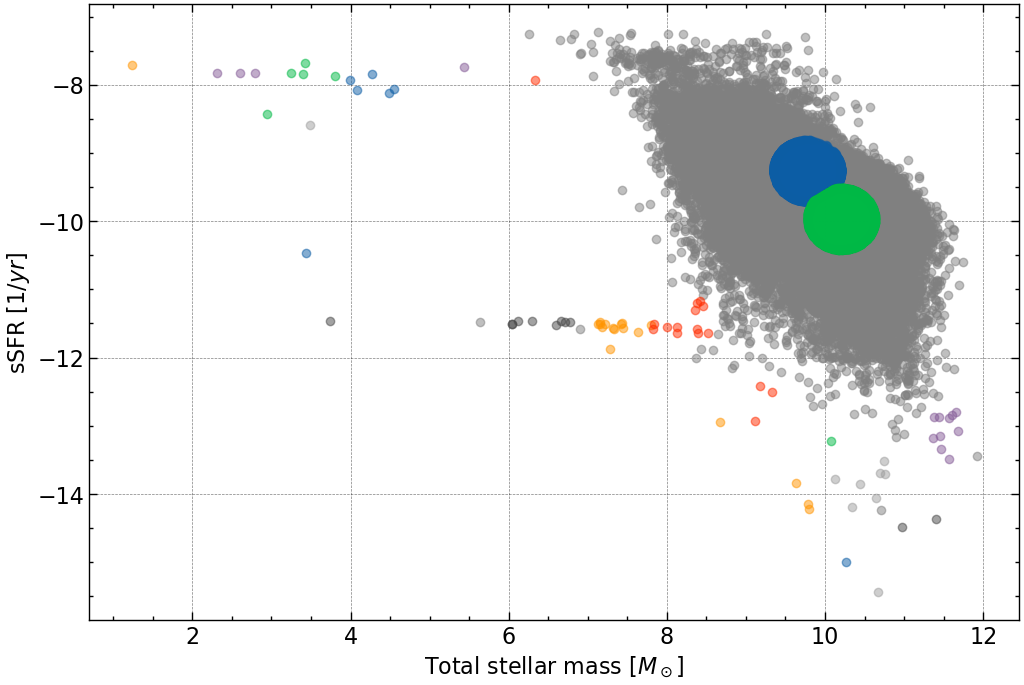

In [11]:
fig = PlotClusters(labels)

## 3) DBSCAN

[DBSCAN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

The computation takes a while

In [12]:
from sklearn.cluster import DBSCAN

# Initialize DBSCAN object
dbscan = DBSCAN(eps=0.5, min_samples=500, n_jobs=1)

# Fit model on data
labels = dbscan.fit_predict(X)

labels = [-1  0]
number of estimated clusters : 1


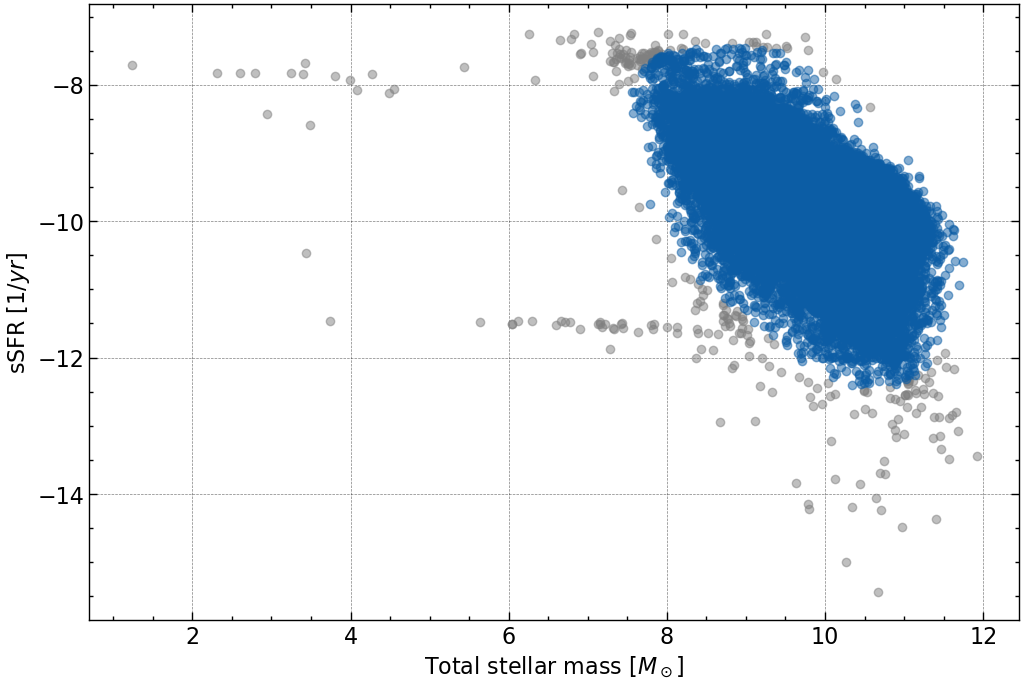

In [13]:
fig = PlotClusters(labels)

# Bimodal gaussian fit

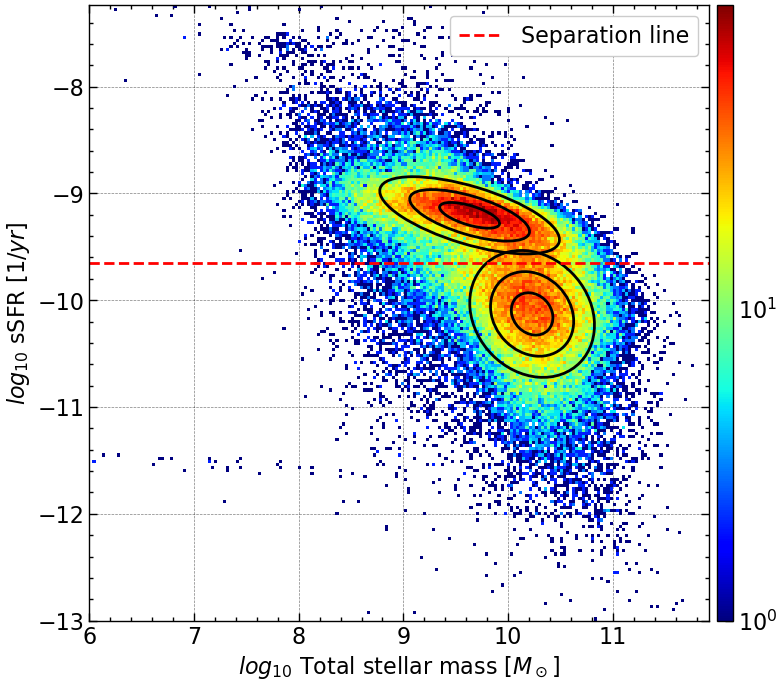

In [14]:
# Base code drawn from Ivezic, Figure 3.22, edited by G. Richards to simplify the example

from matplotlib.patches import Ellipse
from astroML.stats import fit_bivariate_normal

x_data = np.log10(results['best.stellar.m_star'])
y_data = np.log10(results['bayes.sfh.sfr10Myrs']/results['best.stellar.m_star'])

x_min = 6
x_max = np.max(x_data)
y_min = -13
y_max = np.max(y_data)
hist2d_nbins = 200

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
hist = ax.hist2d(x_data, y_data, bins=(binx, biny), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
cax = fig.add_axes([0.91, 0.11, 0.02, 0.77])
fig.colorbar(hist[3], cax=cax)

y_separator = -9.65
ax.axhline(y_separator, color='red', ls='--', label='Separation line')

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');


# Fit the main sequence with a bivariate normal distribution and plot it via robust estimators
mask = y_data >= y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec='black', fc='none'))
    
    
# Fit the passive region with a bivariate normal distribution and plot it via robust estimators
mask = y_data < y_separator
x_fit = np.array(x_data[mask])
y_fit = np.array(y_data[mask])
mean_r, sigma_x_r, sigma_y_r, alpha_r = fit_bivariate_normal(x_fit, y_fit, robust=True)

for N in (1, 2, 3):
    ax.add_patch(Ellipse(mean_r, N * sigma_x_r, N * sigma_y_r, 
                         angle=alpha_r * 180./np.pi, lw=2, 
                         ec='black', fc='none'))
    
ax.legend()

# 3D Histogram

In [15]:
run_3dHist = False

if run_3dHist:
    
    # Initialize the data (in log-scale) and the boundaries
    x_data = np.log10(results['best.stellar.m_star'])
    y_data = np.log10(results['bayes.sfh.sfr10Myrs']/results['best.stellar.m_star'])

    x_min = 6
    x_max = np.max(x_data)
    y_min = -13
    y_max = np.max(y_data)
    hist2d_nbins = 200

    # Make the 3d plot interactive
    %matplotlib widget

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initialize the histogram
    binx = np.linspace(start=x_min, stop=x_max, num=hist2d_nbins)
    biny = np.linspace(start=y_min, stop=y_max, num=hist2d_nbins)
    hist, xedges, yedges = np.histogram2d(x_data, y_data, bins=(binx, biny))

    # Positions of the bars
    xpos, ypos = np.meshgrid((xedges[:-1]+xedges[1:])/2, (yedges[:-1]+yedges[1:])/2)
    xpos = xpos.flatten()
    ypos = ypos.flatten()
    zpos = np.zeros_like (xpos)

    # Sizes of the bars
    dx = xedges[1] - xedges[0]
    dy = yedges[1] - yedges[0]
    dz = hist.flatten()

    # Colormap: scale each z to [0,1] and get their rgb values
    cmap = matplotlib.colormaps.get_cmap('jet') 
    rgba = [cmap((k-np.min(dz))/np.max(dz)) for k in dz] 

    # Set the height of the bars in log-scale
    for i in range(len(dz)):
        if dz[i]>0: dz[i] = np.log10(dz[i])

    # Plot the 3D histogram
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('$log_{10}$ Total stellar mass $[M_\odot]$')
    ax.set_ylabel('$log_{10}$ sSFR $[1/yr]$');